### This notebook extracts data that is required by the turbulence model to run
1. Identify potential water columns of interest - begin with the FRIS sill
1. Get vertical density profile of profiles of interest
1. Get pressure gradient $\nabla_{x,y} P$ between profiles of interest and points that are to the north and to the east. Ensure that there is less time interval between measurement of these water columns to make the gradient accurate

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gsw
import pdb
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import Image
import matplotlib.colors as colors
from scipy.interpolate import griddata
import geopandas as gpd
from shapely.geometry import Point

<IPython.core.display.Javascript object>


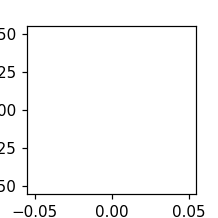

In [102]:
%matplotlib notebook
plt.figure(figsize=(2,2))
plt.plot()
plt.show()

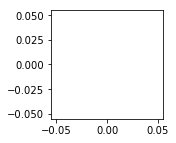

In [313]:
%matplotlib inline
plt.figure(figsize=(2,2))
plt.plot()
plt.show()

In [4]:
dfmg = pd.read_csv("dfmg_glDist.csv")
del dfmg['Unnamed: 0']
del dfmg['Unnamed: 0.1']
dfmg.loc[:,'JULD'] = pd.to_datetime(dfmg.loc[:, 'JULD'])

In [132]:
import plot_stations as pltStn
import importlib
importlib.reload(pltStn)

<module 'plot_stations' from '/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_stations.py'>

In [6]:
import plot_bathy as pltBathy
import importlib
importlib.reload(pltBathy)

<module 'plot_bathy' from '/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_bathy.py'>

In [7]:
import find_depth_averages_v2 as averageProfile
import plot_var_contours_with_distance as plt2dDepthVsDist

In [268]:
WSO_source = (dfmg['CTEMP'] <= -1.7 ) & (dfmg["PSAL_ADJUSTED"] > 34.5)
WSO_prod = (dfmg['CTEMP'] <= -0.8) & (dfmg['CTEMP'] >= -1.2) & (dfmg["PSAL_ADJUSTED"] > 34.5)

In [269]:
def get_mask_from_prof_mask(df, profmask):
    profs = dfmg.loc[profmask, 'PROFILE_NUMBER'].unique()
    mask = dfmg.loc[:, 'PROFILE_NUMBER'].isin(profs)
    
    return mask

WSO_source = get_mask_from_prof_mask(dfmg, WSO_source)
WSO_prod = get_mask_from_prof_mask(dfmg, WSO_prod)

In [9]:
import plot_station_bot_sal as pbs

In [10]:
def sel_months(df, months=[1]):
    return df['JULD'].dt.month.isin(months)

In [12]:
box1 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -60) & (dfmg["LONGITUDE"] < -40)
box2 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -40) & (dfmg["LONGITUDE"] < -20)
box3 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -60) & (dfmg["LONGITUDE"] < -40)
box4 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -40) & (dfmg["LONGITUDE"] < -20)

box5 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > 160) & (dfmg["LONGITUDE"] < 180)
box6 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -180) & (dfmg["LONGITUDE"] < -160)
box7 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > 160) & (dfmg["LONGITUDE"] < 180)
box8 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -180) & (dfmg["LONGITUDE"] < -160)

box9 = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 60) & (dfmg["LONGITUDE"] < 70)
box10 = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 70) & (dfmg["LONGITUDE"] < 80)

In [13]:
Weddell = (box1 | box2 | box3| box4)
Ross = (box5 | box6 | box7 | box8)
Prydz = (box9 | box10)
EBS = (dfmg['LONGITUDE'] > -80) & (dfmg['LONGITUDE'] < -60) #Eastern Bellingshausen Sea
WBS = (dfmg['LONGITUDE'] > -100) & (dfmg['LONGITUDE'] < -80) # Western Bellingshausen Sea

In [14]:
dfmg['mab'] = abs(dfmg['ECHODEPTH'] - dfmg['DEPTH'])
lt60 = abs(dfmg['mab']) < 60
lt100 = abs(dfmg['mab']) < 100
lt200 = abs(dfmg['mab']) < 200

In [15]:
lowSurfSal = (dfmg['PSAL_ADJUSTED'] < 33.5) & (dfmg['DEPTH'] > -100)
cdw = (dfmg['PSAL_ADJUSTED'] > 34.6) & (dfmg['CTEMP'] > 0)
maxTemp = (dfmg.groupby('PROFILE_NUMBER')['CTEMP'].transform(max) == dfmg['CTEMP'])
gline_le_50km = dfmg['DIST_GLINE'] <= 50
gline_le_100km = dfmg['DIST_GLINE'] <= 100
gline_le_150km = dfmg['DIST_GLINE'] <= 150
gline_le_25km = dfmg['DIST_GLINE'] <= 25

In [16]:
def play_beep():
    import os
    duration = 0.5  # second
    freq = 440  # Hz
    os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (duration, freq))
play_beep()

In [274]:
year_mask = dfmg.loc[:, 'JULD'].dt.year == 2011
month_mask = dfmg.loc[:, 'JULD'].dt.month == 3

mask_selection = year_mask & month_mask & Weddell & WSO_source
time_vector = dfmg.loc[dfmg.loc[mask_selection].\
                       groupby('PROFILE_NUMBER').head(1).index, 'JULD'].astype(pd.datetime).values

profile_numbers = dfmg.loc[dfmg.loc[mask_selection].\
                           groupby('PROFILE_NUMBER').head(1).index, 'PROFILE_NUMBER'].values

sorted_indices = np.argsort(time_vector)
time_vector = time_vector[sorted_indices]
profile_numbers = profile_numbers[sorted_indices]
diff = np.diff(time_vector)
for i in range(len(diff)):
    diff[i] = diff[i].total_seconds()/3600.
len(diff)

677

In [82]:
profile_numbers[np.where(diff <= 1)[0]]

array([259041, 262336, 260184, ..., 254733, 259187, 257230])

In [84]:
diff_indices_le1 = np.where(diff <= 1)[0]

In [85]:
np.where((diff_indices_le1[1:] - diff_indices_le1[:-1]) == 1)

(array([   1,    2,    3, ..., 2182, 2183, 2184]),)

In [86]:
diff_indices_le1[0:10]

array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [87]:
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

In [92]:
consec = consecutive(diff_indices_le1)
streak_len = np.zeros(len(consec))
for i in range(len(consec)):
    streak_len[i] = len(consec[i])
np.argmax(streak_len)

In [95]:
profile_numbers[consec[87]]

array([260840, 259140, 262435, 258152, 254697, 258658, 255119, 260280,
       259643, 261355, 257177, 257959, 256648, 255871, 262076, 253936,
       258659, 261356, 260841, 262436, 254698, 259644, 253445, 257178,
       259141, 255120, 260281, 257960, 260282, 261357, 255872, 258660,
       259645, 255121, 256649, 262437, 260842, 257179, 253937, 259142,
       262077, 253446, 255873, 257961, 261358, 255122, 262438, 253938,
       259646, 256650, 258153, 253447, 258661, 263106, 257180, 260843,
       262078, 255874, 263107, 254699, 256651, 259143, 257181, 258662,
       255123, 258154, 262079, 260283])

<IPython.core.display.Javascript object>


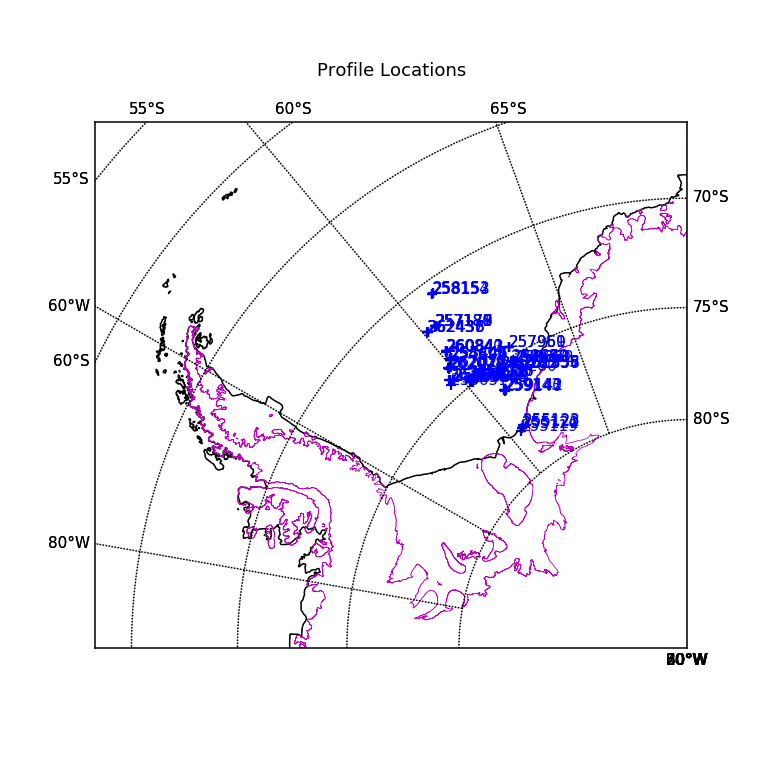

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_stations.py:63: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  else:


In [137]:
mask = dfmg.loc[:, 'PROFILE_NUMBER'].isin(profile_numbers[consec[87]])
positions = dfmg.loc[dfmg[mask].groupby('PROFILE_NUMBER').tail(1).index, 'LATITUDE':'LONGITUDE'].values
markers = dfmg.loc[dfmg[mask].groupby('PROFILE_NUMBER').tail(1).index, 'PROFILE_NUMBER'].values
pltStn.plot_station_locations(positions, title='Profile Locations', wd=7, ht=7, 
                              region='Weddell', markers=markers)

In [141]:
def print_prof_details(dfmg, selected_profs):
    mask_sel_profiles = dfmg.loc[:, 'PROFILE_NUMBER'].isin(selected_profs)
    print(dfmg.loc[dfmg[mask_sel_profiles].groupby('PROFILE_NUMBER').head(1).index, 
                  'JULD'].sort_values().values)
    print(dfmg.loc[dfmg.loc[dfmg[mask_sel_profiles].groupby('PROFILE_NUMBER').head(1).index, 
                  'JULD'].sort_values().index, 'PROFILE_NUMBER'].values)

In [142]:
selected_profiles1 = [256650, 256649, 256648, 256651, 263107, 263106]
print_prof_details(dfmg, selected_profiles1)

['2011-03-21T08:08:00.009600000' '2011-03-21T13:05:59.971200000'
 '2011-03-21T17:15:59.961600000' '2011-03-21T18:20:00.009600000'
 '2011-03-21T20:15:59.961600000' '2011-03-21T21:15:59.990400000']
[256648 256649 256650 263106 263107 256651]


In [143]:
dfmg.loc[dfmg.loc[:, 'PROFILE_NUMBER'].isin(selected_profiles1)].groupby(
'PROFILE_NUMBER').tail(1)

,JULD,LATITUDE,LONGITUDE,PLATFORM_NUMBER,POSITION_QC,PRES_ADJUSTED,PRES_ADJUSTED_QC,PROFILE_NUMBER,PSAL_ADJUSTED,PSAL_ADJUSTED_QC,...,TEMP_ADJUSTED_QC,DEPTH,DENSITY_INSITU,POT_DENSITY,CTEMP,DENSITY_GRADIENT,ECHODEPTH,mab,deep_flag,DIST_GLINE
1824449,2011-03-21 08:08:00.009600,-74.3591,-41.1726,b'00021108',b'1',366.0,1,256648,34.612000,1,...,1,-361.888851,1029.631547,27.873645,-1.809460,-0.000183,-364.0,2.111149,1.0,440.290533
1824469,2011-03-21 13:05:59.971200,-74.3208,-41.1489,b'00021108',b'1',351.0,1,256649,34.625000,1,...,1,-347.070538,1029.568276,27.882733,-1.760004,-0.001016,-375.0,27.929462,1.0,444.606109
1824489,2011-03-21 17:15:59.961600,-74.2886,-41.1290,b'00021108',b'1',343.0,1,256650,34.620998,1,...,1,-339.167171,1029.526440,27.879221,-1.753813,-0.000265,-389.0,49.832829,1.0,448.234412
1824509,2011-03-21 21:15:59.990400,-74.3931,-41.8641,b'00021108',b'1',370.0,1,256651,34.620499,1,...,1,-365.839794,1029.655708,27.879254,-1.762975,0.000103,-378.0,12.160206,1.0,433.371108
1948032,2011-03-21 18:20:00.009600,-74.2044,-41.6319,b'00021024',b'1',431.0,1,263106,34.633297,1,...,1,-426.095137,1029.949277,27.884058,-1.570941,0.000099,-419.0,7.095137,1.0,454.964275
1948052,2011-03-21 20:15:59.961600,-74.2010,-41.5490,b'00021024',b'1',434.0,1,263107,34.635799,1,...,1,-429.057966,1029.963333,27.884506,-1.521171,0.000099,-417.0,12.057966,1.0,455.613287


In [144]:
selected_profiles2 = [259646, 259645, 259644, 259643]
print_prof_details(dfmg, selected_profiles2)

['2011-03-21T07:27:59.990400000' '2011-03-21T09:42:00.028800000'
 '2011-03-21T13:02:00.038400000' '2011-03-21T17:14:00.038400000']
[259643 259644 259645 259646]


In [145]:
selected_profiles3 = [259143, 259142, 259141, 259140]
print_prof_details(dfmg, selected_profiles3)

['2011-03-21T06:22:00.019200000' '2011-03-21T11:03:59.990400000'
 '2011-03-21T14:14:00.038400000' '2011-03-21T21:24:00.028800000']
[259140 259141 259142 259143]


In [146]:
selected_profiles4 = [255871, 255872, 255873, 255874]
print_prof_details(dfmg, selected_profiles4)

['2011-03-21T08:19:59.980799999' '2011-03-21T12:49:59.980800000'
 '2011-03-21T16:14:00.009600000' '2011-03-21T20:14:00.038400000']
[255871 255872 255873 255874]


In [280]:
import xarray as xr
U10 = xr.open_dataset("/media/data/Datasets/ESRL_U10/uwnd.10m.gauss.2011.nc")

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/xarray/conventions.py:9: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [281]:
U10.variables

Frozen(OrderedDict([('lat', <xarray.Coordinate 'lat' (lat: 94)>
array([ 88.54199982,  86.65309906,  84.75319672,  82.85079956,
        80.94730377,  79.04350281,  77.13939667,  75.23509979,
        73.33070374,  71.42620087,  69.521698  ,  67.61710358,
        65.71250153,  63.80789948,  61.90330124,  59.99860001,
        58.09389877,  56.18930054,  54.2845993 ,  52.37990189,
        50.47520065,  48.57049942,  46.66579819,  44.76110077,
        42.85639954,  40.9516983 ,  39.04700089,  37.14220047,
        35.23749924,  33.33280182,  31.42810059,  29.52339935,
        27.61860085,  25.71389961,  23.80920029,  21.90439987,
        19.99970055,  18.09499931,  16.19020081,  14.28549957,
        12.38080025,  10.47603989,   8.57131004,   6.66657019,
         4.76183987,   2.85710001,   0.95236802,  -0.95236802,
        -2.85710001,  -4.76183987,  -6.66657019,  -8.57131004,
       -10.47603989, -12.38080025, -14.28549957, -16.19020081,
       -18.09499931, -19.99970055, -21.90439987, -23.8

In [395]:
x = np.array(U10['uwnd'][79, 86, 77].values)
np.asscalar(x)

1.1699981689453125

In [402]:
np.asscalar(np.argmin(np.abs(U10['lat'] - lat)))

86

In [407]:
def get_U10_value(U10, lat, lon, time):
    latind = np.asscalar(np.argmin(np.abs(U10['lat'] - lat)))
    lonind = np.asscalar(np.argmin(np.abs(U10['lon'] - (lon+180))))
    timeind = np.where(U10['time'].values.astype('<M8[D]') == time)[0][0]

    return np.asscalar(U10['uwnd'][timeind][latind][lonind])

In [404]:
lat = -75
lon = -35
time = np.datetime64('2011-03-21')
latind = np.asscalar(np.argmin(np.abs(U10['lat'] - lat)))
lonind = np.asscalar(np.argmin(np.abs(U10['lon'] - (lon+180))))
timeind = np.where(U10['time'].values.astype('<M8[D]') == time)[0][0]
print(timeind, latind, lonind)
np.asscalar(U10['uwnd'][timeind][latind][lonind])

79 86 77


1.1699981689453125

In [408]:
get_U10_value(U10, lat, lon, time)

1.1699981689453125

In [354]:
np.argmin(U10['time'] - time)

<xarray.DataArray 'time' ()>
array(0)

In [331]:
dfmg

,JULD,LATITUDE,LONGITUDE,PLATFORM_NUMBER,POSITION_QC,PRES_ADJUSTED,PRES_ADJUSTED_QC,PROFILE_NUMBER,PSAL_ADJUSTED,PSAL_ADJUSTED_QC,...,TEMP_ADJUSTED_QC,DEPTH,DENSITY_INSITU,POT_DENSITY,CTEMP,DENSITY_GRADIENT,ECHODEPTH,mab,deep_flag,DIST_GLINE
0,2007-03-03 03:24:00.028799999,-68.5139,78.3736,b'00012048',b'1',6.0,1,0,NaN,9,...,1,-5.939708,NaN,NaN,NaN,NaN,-1.0,4.939708,0.0,4.188420
1,2007-03-03 03:24:00.028799999,-68.5139,78.3736,b'00012048',b'1',8.0,1,0,NaN,9,...,1,-7.919572,NaN,NaN,NaN,NaN,-1.0,6.919572,0.0,4.188420
2,2007-03-03 03:24:00.028799999,-68.5139,78.3736,b'00012048',b'1',14.0,1,0,NaN,9,...,1,-13.859049,NaN,NaN,NaN,NaN,-1.0,12.859049,0.0,4.188420
3,2007-03-03 03:24:00.028799999,-68.5139,78.3736,b'00012048',b'1',18.0,1,0,NaN,9,...,1,-17.818605,NaN,NaN,NaN,NaN,-1.0,16.818605,0.0,4.188420
4,2007-03-03 03:24:00.028799999,-68.5139,78.3736,b'00012048',b'1',22.0,1,0,NaN,9,...,1,-21.778083,NaN,NaN,NaN,NaN,-1.0,20.778083,0.0,4.188420
5,2007-03-03 03:24:00.028799999,-68.5139,78.3736,b'00012048',b'1',28.0,1,0,NaN,9,...,1,-27.717157,NaN,NaN,NaN,NaN,-1.0,26.717157,0.0,4.188420
6,2007-03-03 03:24:00.028799999,-68.5139,78.3736,b'00012048',b'1',30.0,1,0,NaN,9,...,1,-29.696809,NaN,NaN,NaN,NaN,-1.0,28.696809,0.0,4.188420
7,2007-03-03 03:24:00.028799999,-68.5139,78.3736,b'00012048',b'1',32.0,1,0,NaN,9,...,1,-31.676443,NaN,NaN,NaN,NaN,-1.0,30.676443,0.0,4.188420
8,2007-03-03 03:24:00.028799999,-68.5139,78.3736,b'00012048',b'1',38.0,1,0,NaN,9,...,1,-37.615228,NaN,NaN,NaN,NaN,-1.0,36.615228,0.0,4.188420
9,2007-03-03 03:24:00.028799999,-68.5139,78.3736,b'00012048',b'1',50.0,1,0,NaN,9,...,1,-49.492280,NaN,NaN,NaN,NaN,-1.0,48.492280,0.0,4.188420


In [417]:
def get_pressure_gradient(df, profile_pair):
    from haversine import haversine
    from scipy import interpolate
    mask1 = df.loc[:, 'PROFILE_NUMBER'].isin([profile_pair[0]])
    mask2 = df.loc[:, 'PROFILE_NUMBER'].isin([profile_pair[1]])
    
    position1 = np.array(df.loc[df.loc[mask1].tail(1).index,'LATITUDE':'LONGITUDE'].values)[0]
    position2 = np.array(df.loc[df.loc[mask2].tail(1).index,'LATITUDE':'LONGITUDE'].values)[0]
    
    xsign = (position2[1] - position1[1]) / abs(position1[1] - position2[1])
    ysign = (position2[0] - position1[0]) / abs(position1[0] - position2[0])
    
    deltaY = haversine([position1[0], position1[1]], [position2[0], position1[1]])
    deltaX = haversine([position1[0], position1[1]], [position1[0], position2[1]])
    distance = haversine([position1[0], position1[1]], [position2[0], position2[1]])
    
    depth1 = df.loc[mask1, 'DEPTH'].values
    press1 = df.loc[mask1, 'PRES_ADJUSTED'].values * 1e4
    rho1 = df.loc[mask1, 'DENSITY_INSITU'].values
    lat1 = df.loc[mask1, 'LATITUDE'].tail(1).values[0]
    lon1 = df.loc[mask1, 'LONGITUDE'].tail(1).values[0]
    
    depth2 = df.loc[mask2, 'DEPTH'].values
    press2 = df.loc[mask2, 'PRES_ADJUSTED'].values * 1e4
    rho2 = df.loc[mask2, 'DENSITY_INSITU'].values
    lat2 = df.loc[mask2, 'LATITUDE'].tail(1).values[0]
    lon2 = df.loc[mask2, 'LONGITUDE'].tail(1).values[0]
    
    depth_regridded = np.arange(min([max(depth1) ,max(depth2)]) , max([min(depth1) ,min(depth2)]), -10)
    
    interp_func = interpolate.interp1d(depth1, press1)
    press1_regridded = interp_func(depth_regridded)
    
    interp_func = interpolate.interp1d(depth2, press2)
    press2_regridded = interp_func(depth_regridded)
    
    interp_func = interpolate.interp1d(depth1, rho1)
    rho1_regridded = interp_func(depth_regridded)
    
    interp_func = interpolate.interp1d(depth2, rho2)
    rho2_regridded = interp_func(depth_regridded)
    
    press_grad = (press2_regridded - press1_regridded)/(distance * 1e3)
    theta = np.arctan(deltaY/deltaX)
    press_grad_x = press_grad * np.cos(theta) * xsign
    press_grad_y = press_grad * np.sin(theta) * ysign
    
    # Reversing arrays to make it bottom to top order (0 at bed and increasing upwards)
    depth_regridded = (-depth_regridded[-1] + depth_regridded)[::-1]
    
    return lat2, depth_regridded, rho2_regridded[::-1], press_grad_x[::-1], press_grad_y[::-1]
    

In [426]:
lat, depth, rho, dp_x, dp_y = get_pressure_gradient(dfmg, [263107, 256651])
resvel = [0.1, 0.1] #initial guess velocities at bottom and top

In [ ]:
%%capture
import TBS
importlib.reload(TBS)
outdir = "./Results/"

Model = TBS.Keps_Solver(200, lat, depth, dp_x, dp_y, rho, resvel, 5, outdir, "Vars")
Model.solver(36000, 1, 300)

In [431]:
len((Model.nu_t[1:] + Model.nu_t[:-1]) *0.5 + Model.nu)

199

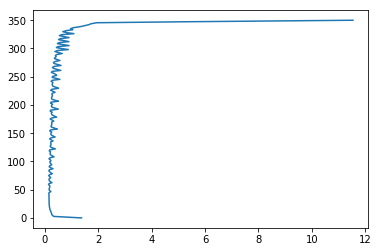

In [422]:
plt.plot(Model.u, Model.y_mom)

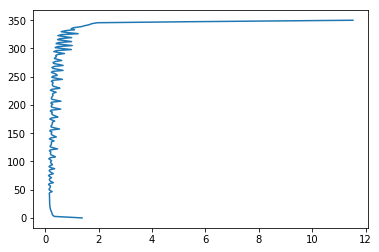

In [423]:
plt.plot(Model.v, Model.y_mom)

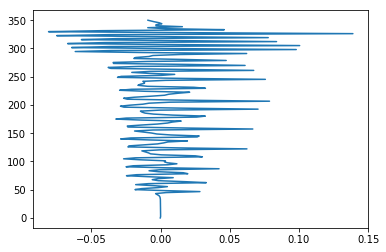

In [425]:
plt.plot(Model.v - Model.u, Model.y_mom)

In [420]:
dp_y

array([ -1.30757151e-03,  -1.17584559e-03,  -1.27912536e-03,
        -1.09448857e-03,  -1.23628866e-03,  -1.02930376e-03,
        -1.12604792e-03,  -9.92025000e-04,  -1.02213843e-03,
        -9.46096896e-04,  -9.19051549e-04,  -8.99109380e-04,
        -8.05318062e-04,  -8.80212117e-04,  -7.19618222e-04,
        -8.38607914e-04,  -6.19570578e-04,  -7.24432567e-04,
        -5.65754872e-04,  -6.21770620e-04,  -4.99409966e-04,
        -5.29735891e-04,  -4.64411870e-04,  -4.27856147e-04,
        -4.57730865e-04,  -3.54236855e-04,  -3.95787300e-04,
        -2.66373377e-04,  -2.84810032e-04,  -2.06897610e-04,
        -2.02136150e-04,  -1.33257271e-04,  -1.05208821e-04,
        -8.81323679e-05,  -3.67123698e-05,  -2.89229346e-05])

In [298]:
Model.dy1

0.0025

In [303]:
Model.ustar[-1]

0.0086316636346175091

In [305]:
0.03 * 5 * np.sqrt(2.5*1e-3)

0.0074999999999999997

In [307]:
Model.ustar

array([ 0.23353588,  0.00863166])